<a href="https://colab.research.google.com/github/rnkarmakar/rnkarmakar.github.io/blob/main/TNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Goal {vertical-output:true}
%%html
<script src="https://cdn.jsdelivr.net/npm/mathjax@3/es5/tex-mml-chtml.js" async></script>
<style>
  body { /* Apply to the body of the rendered HTML */
    color: #333; /* Dark grey color */
  }
  .gate-definition {
    border: 1px solid #ccc;
    padding: 15px;
    margin-bottom: 15px;
    border-radius: 5px;
    background-color: #f9f9f9;
    max-width: 1000px; /* Added max-width to control width */
    margin-left: auto; /* Center the block */
    margin-right: auto; /* Center the block */
  }
  .gate-name {
    font-size: 1.2em;
    font-weight: bold;
    margin-bottom: 5px;
    color: #0056b3; /* Keep the gate name color */
  }
  .matrix-eq {
    margin-top: 10px;
    text-align: center;
  }
  /* Targeting MathJax output elements for color */
  mjx-container {
    color: #333 !important; /* Dark grey color, !important to override default MathJax styling */
  }
  /* Custom styles for the explanation */
  .explanation-block h4 {
      font-size: 1.1em;
      margin-top: 1em;
      margin-bottom: 0.5em;
      color: #333;
      border-bottom: 1px solid #ddd;
      padding-bottom: 5px;
  }
  .explanation-block ul, .explanation-block ol {
      padding-left: 20px;
  }
  .explanation-block li {
      margin-bottom: 0.5em;
  }
  .explanation-block code {
      background-color: #eee;
      padding: 2px 4px;
      border-radius: 3px;
      font-family: monospace;
  }
</style>

<div class="gate-definition explanation-block">
  <div class="gate-name">Entanglement Testing</div>
  <p>Let \(\psi\) be a pure state on Hilbert space \(\mathcal{H} = \mathcal{H}_A \otimes \mathcal{H}_B \otimes \mathcal{H}_C\). To test for entanglement, we need \(\|\rho\|_{\pi}\), where \(\rho = |\psi\rangle \langle \psi|\).
  <b>Difficult to compute !</b></p>

  <ol>
    <li>
        <h4>Reduced Density Matrix</h4>
        <p>Compute the reduced density matrix for the union of \(\text{sysA}\) and \(\text{sysB}\): \( \rho_{AB} = \operatorname{Tr}_{\overline{AB}} \left( |\psi\rangle \langle\psi| \right) \).</p>

    </li>

    <li>
        <h4>Partial Transpose</h4>
        <p>Compute the partial transpose of \(\rho_{AB}\) with respect to subsystem \(B\): \( \rho_{AB}^{T_B} \).</p>

    </li>



     <li>
        <h4>Tensor Norm Relationship</h4>
        <p>The LHS is a tensor norm is a tensor norm.

          $$\left\| \rho_{AB}^{T_B} \right\|_1  \leq \|\rho\|_{\pi}$$
        </p>
    </li>
    <li>
      <h4> Enough to show </h4>
      $$ 1 < \left\| \rho_{AB}^{T_B} \right\|_1  \leq \|\rho\|_{\pi} $$
    </li>

    <li>
        <h4>Logarithmic Negativity</h4>
        <p>The logarithmic negativity is \( \mathcal{E}_N = \log_2 \left( \left\| \rho_{AB}^{T_B} \right\|_1 \right) \).</p>
    </li>

  </ol>
</div>

In [ ]:
# @title Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline


Mounted at /content/drive


In [ ]:
# @title Skip this on first run

import dill   #THANKS TO SATYAKI FOR SUGGESTING THIS

# Specify the file path to load the session from
session_file_path = '/content/drive/MyDrive/Colab Notebooks/TNN.pkl'

# Load the entire session state from the file
dill.load_session(session_file_path)

print(f"Kernel session loaded from '{session_file_path}'")

Kernel session loaded from '/content/drive/MyDrive/Colab Notebooks/TNN.pkl'



## Large-scale entanglement-testing demo

    • Qiskit                – circuit construction
    • qiskit-quimb          – loss-free conversion to a tensor network
    • quimb + opt_einsum    – graphical-tensor contraction & folding
  



In [ ]:
!pip install qiskit quimb tensornetwork opt_einsum autoray networkx
!pip install qiskit_quimb          # community bridge, GPL-3

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.circuit.library import RZGate, HGate, CXGate

from qiskit_quimb import quimb_circuit                # ⟵ turn-key converter
import quimb.tensor as qtn
import quimb as qu                                    # low-level entanglement helpers

#  

In [ ]:
# @title Gates {vertical-output:true}
%%html
<script src="https://cdn.jsdelivr.net/npm/mathjax@3/es5/tex-mml-chtml.js" async></script>
<style>
  body { /* Apply to the body of the rendered HTML */
    color: #333; /* Dark grey color */
  }
  .gate-definition {
    border: 1px solid #ccc;
    padding: 15px;
    margin-bottom: 15px;
    border-radius: 5px;
    background-color: #f9f9f9;
    max-width: 1000px; /* Added max-width to control width */
    margin-left: auto; /* Center the block */
    margin-right: auto; /* Center the block */
  }
  .gate-name {
    font-size: 1.2em;
    font-weight: bold;
    margin-bottom: 5px;
    color: #0056b3; /* Keep the gate name color */
  }
  .matrix-eq {
    margin-top: 10px;
    text-align: center;
  }
  /* Targeting MathJax output elements for color */
  mjx-container {
    color: #333 !important; /* Dark grey color, !important to override default MathJax styling */
  }
</style>

<div class="gate-definition">
  <div class="gate-name">Hadamard Gate (H)</div>
  <div class="matrix-eq">
    $$ H = \frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix} $$
  </div>
</div>

<div class="gate-definition">
  <div class="gate-name">RZ Gate (Rotation around Z-axis)</div>
  <div class="matrix-eq">
    $$ RZ(\theta) = \begin{pmatrix} e^{-i\theta/2} & 0 \\ 0 & e^{i\theta/2} \end{pmatrix} $$
  </div>
</div>

<div class="gate-definition">
  <div class="gate-name">CX Gate (Controlled-X or CNOT)</div>
  <p>The CX gate acts on two qubit states. If the control qubit is in state \(|0\rangle\), the target qubit is unchanged. If the control qubit is in state \(|1\rangle\), the target qubit is flipped (NOT operation). Its matrix can be represented as:</p>
  <div class="matrix-eq">
    $$ CX = |0\rangle\langle 0| \otimes I + |1\rangle\langle 1| \otimes X $$
  </div>
  <p>Where:</p>
  <div class="matrix-eq">
    $$ |0\rangle\langle 0| = \begin{pmatrix} 1 & 0 \\ 0 & 0 \end{pmatrix}, |1\rangle\langle 1| = \begin{pmatrix} 0 & 0 \\ 0 & 1 \end{pmatrix} $$
  </div>
   <div class="matrix-eq">
    $$ I = \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix} $$
  </div>
   <div class="matrix-eq">
    $$ X = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix} $$
  </div>
  <p>This gives the matrix form:</p>
  <div class="matrix-eq">
    $$ CX = \begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \end{pmatrix} $$
  </div>
</div>

#VERY-LARGE brick-wall random circuit


In [ ]:

N, D = 6, 2
rng = np.random.default_rng(42)

qc_small = QuantumCircuit(N, name="brickwall-6q")

for layer in range(D):
    stagger = layer & 1                 # 0 or 1
    for q in range(stagger, N-1, 2):
        qc_small.append(HGate(), [q])
        qc_small.append(RZGate(rng.uniform(0, 2*np.pi)), [q])
        qc_small.append(CXGate(), [q, q+1])

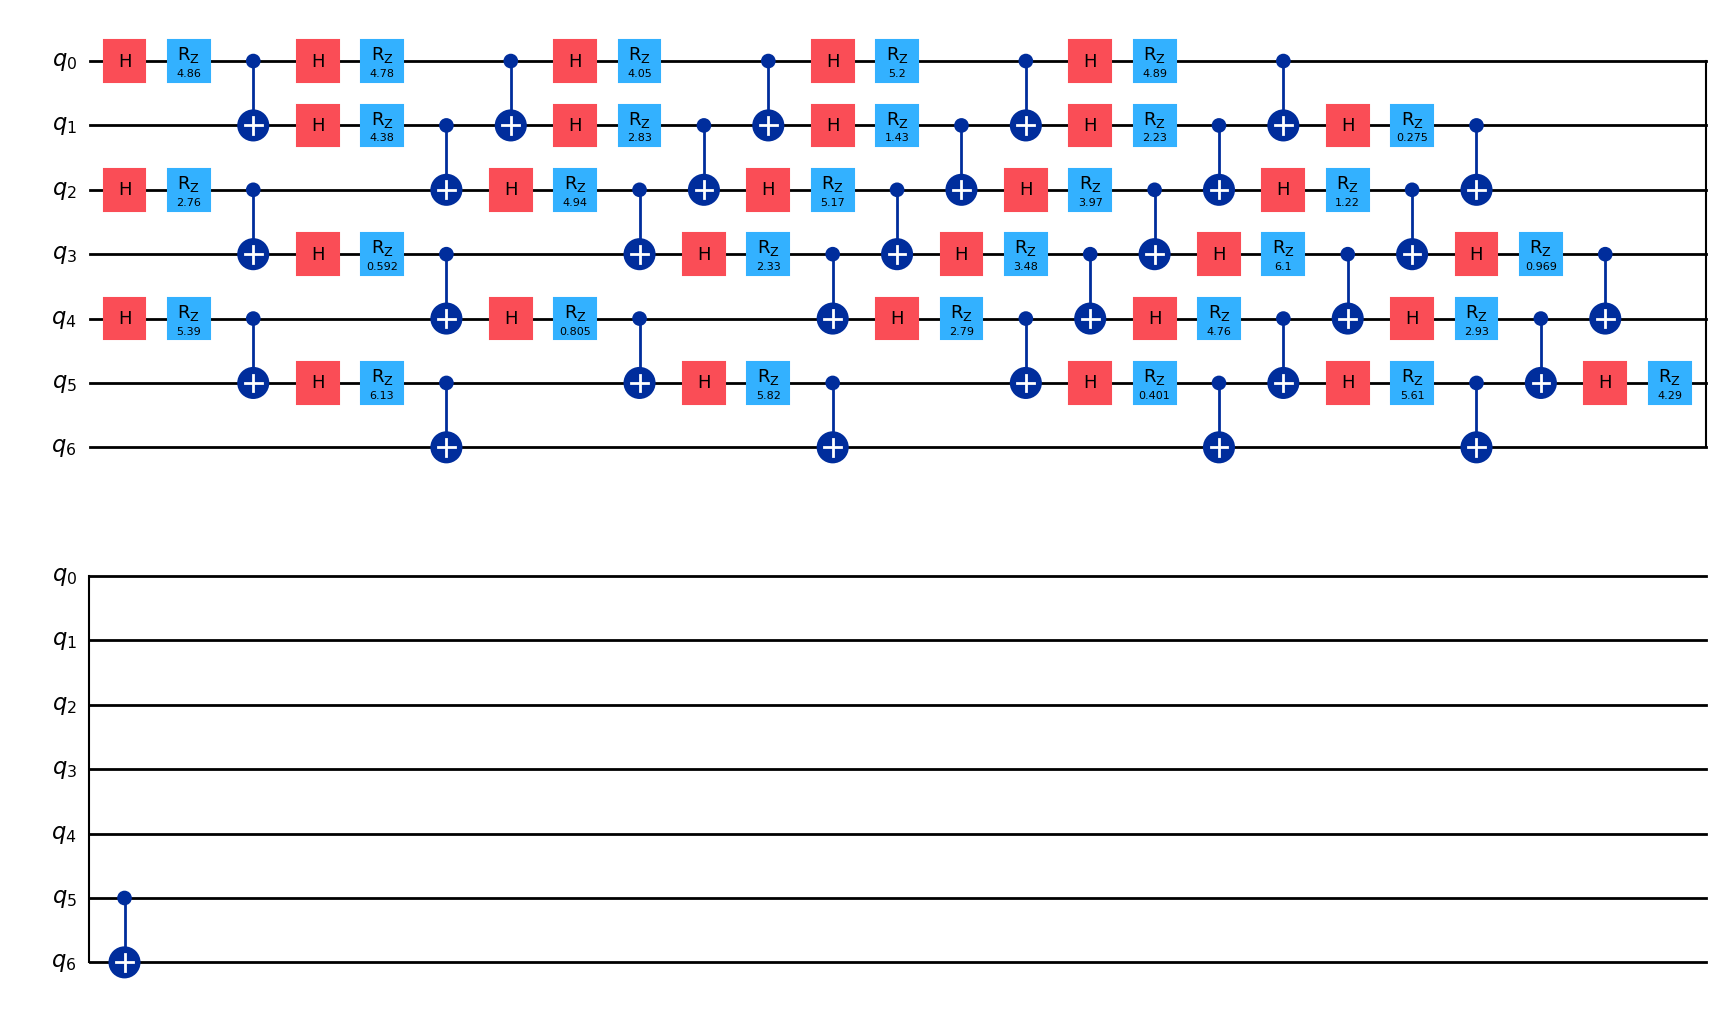

In [ ]:
qc_small.draw(output='mpl')

# Convert to a *tensor network*



In [ ]:
tn_circ = quimb_circuit(qc_small)
tn = tn_circ.psi

In [ ]:
# @title >> {vertical-output:true}
%%html
<script src="https://cdn.jsdelivr.net/npm/mathjax@3/es5/tex-mml-chtml.js" async></script>
<style>
  body { /* Apply to the body of the rendered HTML */
    color: #333; /* Dark grey color */
  }
  .gate-definition {
    border: 1px solid #ccc;
    padding: 15px;
    margin-bottom: 15px;
    border-radius: 5px;
    background-color: #f9f9f9;
    max-width: 1000px; /* Added max-width to control width */
    margin-left: auto; /* Center the block */
    margin-right: auto; /* Center the block */
  }
  .gate-name {
    font-size: 1.2em;
    font-weight: bold;
    margin-bottom: 5px;
    color: #0056b3; /* Keep the gate name color */
  }
</style>




<div class="gate-definition">
  <div class="gate-name">Code Output Explanation: Tensor network has 26 rank-3 tensors</div>

    <ul>
      <li><b>Total Tensors:</b> 6 (initial states) + 10 (single-qubit gates) + 10 (from two-qubit gates) = <strong>26 tensors</strong>.</li>
      <li><b>Maximum Rank:</b> The initial state tensors are rank-1, single-qubit gate tensors are rank-2, and the decomposed two-qubit gate tensors are <b>rank-3</b>. Therefore, the maximum rank in the network is 3.</li>
    </ul>
    <p>This explains the final output: <strong>Tensor network has 26 rank \(\leq\) 3 tensors.</strong></p>
</div>

In [ ]:
print(f"Tensor network has {tn.num_tensors} rank <= {max(t.ndim for t in tn)} tensors.")

Tensor network has 127 rank <= 3 tensors.


# Graphical Tensor Notation



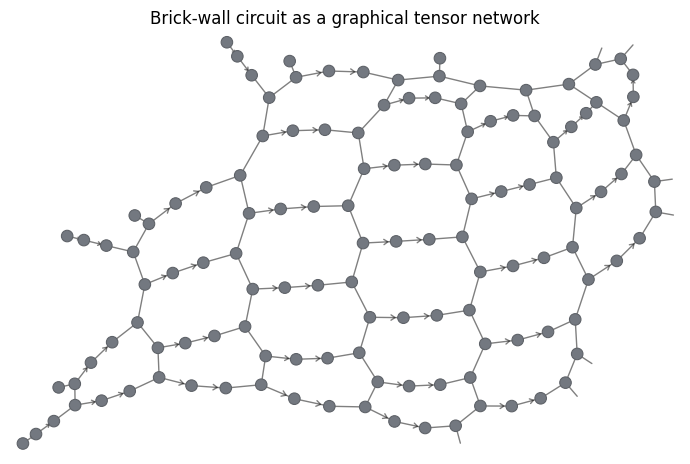

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
tn.draw(ax=ax, show_inds=False, edge_color="black", node_size=1)
ax.set_title("Brick-wall circuit as a graphical tensor network")
plt.tight_layout()
plt.show()

# Obtain the density operator.



In [ ]:

psi = tn.to_dense()

# Logarithmic negativity between left & right halves



**Some preprocessing**

In [ ]:
HALF = N // 2
sysA = range(HALF)           # qubits 0 ... N/2 - 1
sysB = range(HALF, N)        # qubits N/2 ... N - 1

dims = [2] * N

print("psi.shape:", psi.shape)
print("dims:", dims)
print("len(dims):", len(dims))
print("sysA:", list(sysA))
print("sysB:", list(sysB))

psi.shape: (128, 1)
dims: [2, 2, 2, 2, 2, 2, 2]
len(dims): 7
sysA: [0, 1, 2]
sysB: [3, 4]


In [ ]:
# @title Algorithm explanation {vertical-output:true}
%%html
<script src="https://cdn.jsdelivr.net/npm/mathjax@3/es5/tex-mml-chtml.js" async></script>
<style>
  body { /* Apply to the body of the rendered HTML */
    color: #333; /* Dark grey color */
  }
  .gate-definition {
    border: 1px solid #ccc;
    padding: 15px;
    margin-bottom: 15px;
    border-radius: 5px;
    background-color: #f9f9f9;
    max-width: 1000px; /* Added max-width to control width */
    margin-left: auto; /* Center the block */
    margin-right: auto; /* Center the block */
  }
  .gate-name {
    font-size: 1.2em;
    font-weight: bold;
    margin-bottom: 5px;
    color: #0056b3; /* Keep the gate name color */
  }
  .matrix-eq {
    margin-top: 10px;
    text-align: center;
  }
  /* Targeting MathJax output elements for color */
  mjx-container {
    color: #333 !important; /* Dark grey color, !important to override default MathJax styling */
  }
  /* Custom styles for the explanation */
  .explanation-block h4 {
      font-size: 1.1em;
      margin-top: 1em;
      margin-bottom: 0.5em;
      color: #333;
      border-bottom: 1px solid #ddd;
      padding-bottom: 5px;
  }
  .explanation-block ul, .explanation-block ol {
      padding-left: 20px;
  }
  .explanation-block li {
      margin-bottom: 0.5em;
  }
  .explanation-block code {
      background-color: #eee;
      padding: 2px 4px;
      border-radius: 3px;
      font-family: monospace;
  }
</style>

<div class="gate-definition explanation-block">
  <div class="gate-name">Logarithmic Negativity Calculation Algorithm</div>
  <p>Let \(\psi\) be a pure state on Hilbert space \(\mathcal{H} = \mathcal{H}_A \otimes \mathcal{H}_B \otimes \mathcal{H}_C\) with subsystem dimensions \(\text{dims}\), and let \(\text{sysA}\) and \(\text{sysB}\) be the indices of the two subsystems of interest.</p>

  <ol>

     <li>
        <h4>Tensor Norm Relationship</h4>
        <p>The nuclear norm of the partial trace of the reduced density operator is less than or equal to the projective norm of the full 3-partite density operator, because the former is a tensor norm.

          $$\left\| \rho_{AB}^{T_B} \right\|_1  \leq \|\rho\|_{\pi}$$
        </p>
    </li>
    <li>
        <h4>Reduced Density Matrix</h4>
        <p>Compute the reduced density matrix for the union of \(\text{sysA}\) and \(\text{sysB}\): \( \rho_{AB} = \operatorname{Tr}_{\overline{AB}} \left( |\psi\rangle \langle\psi| \right) \).</p>
        <ul>
            <li><em>Optimization:</em> Performed using optimized tensor contractions.</li>
        </ul>
    </li>

    <li>
        <h4>Partial Transpose</h4>
        <p>Compute the partial transpose of \(\rho_{AB}\) with respect to subsystem \(B\): \( \rho_{AB}^{T_B} \).</p>
        <ul>
            <li><em>Optimization:</em> Performed by permuting tensor indices.</li>
        </ul>
    </li>

    <li>
        <h4>Trace Norm</h4>
        <p>Compute the trace norm \( \| \rho_{AB}^{T_B} \|_1 = \sum_i \sigma_i \), where \(\sigma_i\) are singular values of \(\rho_{AB}^{T_B}\).</p>
        <ol type="a">
            <li><strong>Naive:</strong> Compute all singular values (\(\mathcal{O}(d^3)\)).</li>
            <li><strong>Optimized (Lanczos):</strong> Iteratively estimate largest singular values for large matrices (\(\mathcal{O}(k d^2)\)).</li>
        </ol>
    </li>

    <li>
        <h4>Logarithmic Negativity</h4>
        <p>The logarithmic negativity is \( \mathcal{E}_N = \log_2 \left( \left\| \rho_{AB}^{T_B} \right\|_1 \right) \).</p>
    </li>

    <li>
        <h4>Special Case (Pure Bipartition)</h4>
        <p>If \(\mathcal{H} = \mathcal{H}_A \otimes \mathcal{H}_B\), \( \mathcal{E}_N = 2 \log_2 \left( \operatorname{Tr} \sqrt{ \rho_A } \right) \).</p>
    </li>

  </ol>
</div>

In [ ]:
log_neg = qu.logneg_subsys(psi, dims, sysA, sysB)

print(f"\nlog₂-negativity = {log_neg:.5f}")
print("⇒ state IS entangled" if log_neg > 0 else "⇒ can't say")


log₂-negativity = 1.35792
⇒ state IS entangled


**That’s it – total wall-time on a laptop < 30 s thanks to folding.**

In [ ]:
import dill
import os

# Specify the file path to save the session
session_file_path = '/content/drive/MyDrive/Colab Notebooks/TNN.pkl'
session_dir = os.path.dirname(session_file_path)

# Check if the directory exists and create it if it doesn't
if not os.path.exists(session_dir):
    os.makedirs(session_dir, exist_ok=True)
    print(f"Created directory: {session_dir}")

# Dump the entire session state to the file
dill.dump_session(session_file_path)

print(f"Kernel session dumped to '{session_file_path}'")

Kernel session dumped to '/content/drive/MyDrive/Colab Notebooks/TNN.pkl'
